In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.layers import MaxPooling2D, Input, Concatenate, Dense, Dropout, Activation, Flatten, Conv2D, Conv1D, GlobalAveragePooling1D, GlobalAveragePooling2D, BatchNormalization, Flatten, GRU
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

In [2]:
# Compte rendu de classification
def cpt_mal_classes(y_test_func, result_func):
    nb_func = 0
    for i in range(len(y_test_func)):
        if y_test_func[i] != result_func[i]:
            nb_func += 1
    print (f'Taille des données {len(y_test_func)} mal classés {nb_func}\n')

# Plot confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Display image in actual size
def display_image_in_actual_size(im_path):

    dpi = 80
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [3]:
Path('Output').mkdir(exist_ok=True, parents=True)

## Recharger les données d'entraînement, de validation et test en fichier numpy

In [4]:
# Recharger les données après avoir vidé la mémoire
train_X = np.load('Data/train_valid_test/train_X.npy')
train_y = np.load('Data/train_valid_test/train_y.npy')

valid_X = np.load('Data/train_valid_test/valid_X.npy')
valid_y = np.load('Data/train_valid_test/valid_y.npy')
valid_id = np.load('Data/train_valid_test/valid_id.npy')

test_X = np.load('Data/train_valid_test/test_X.npy')
test_id = np.load('Data/train_valid_test/test_id.npy')

train_X1 = train_X[:,2,2,:,:]
valid_X1 = valid_X[:,2,2,:,:]
test_X1 = test_X[:,2,2,:,:]

train_X2 = train_X[:,:,:,:].reshape(train_X.shape[0],20,20,-1)
valid_X2 = valid_X[:,:,:,:].reshape(valid_X.shape[0],20,20,-1)
test_X2 = test_X[:,:,:,:].reshape(test_X.shape[0],20,20,-1)

## Encoder les labels entre 0 et 4 de sorte à matcher les prédictions des réseaux de neurones

In [5]:
encoder = LabelEncoder()

encoder.fit(train_y)
train_y_enc = encoder.transform(train_y)
valid_y_enc = encoder.transform(valid_y)

Model: "cnn1d_cnn2d"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn2d_input (InputLayer)        [(None, 20, 20, 2)]  0                                            
__________________________________________________________________________________________________
cnn1d_input (InputLayer)        [(None, 8, 4)]       0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 32)   1632        cnn2d_input[0][0]                
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 6, 32)        416         cnn1d_input[0][0]                
________________________________________________________________________________________

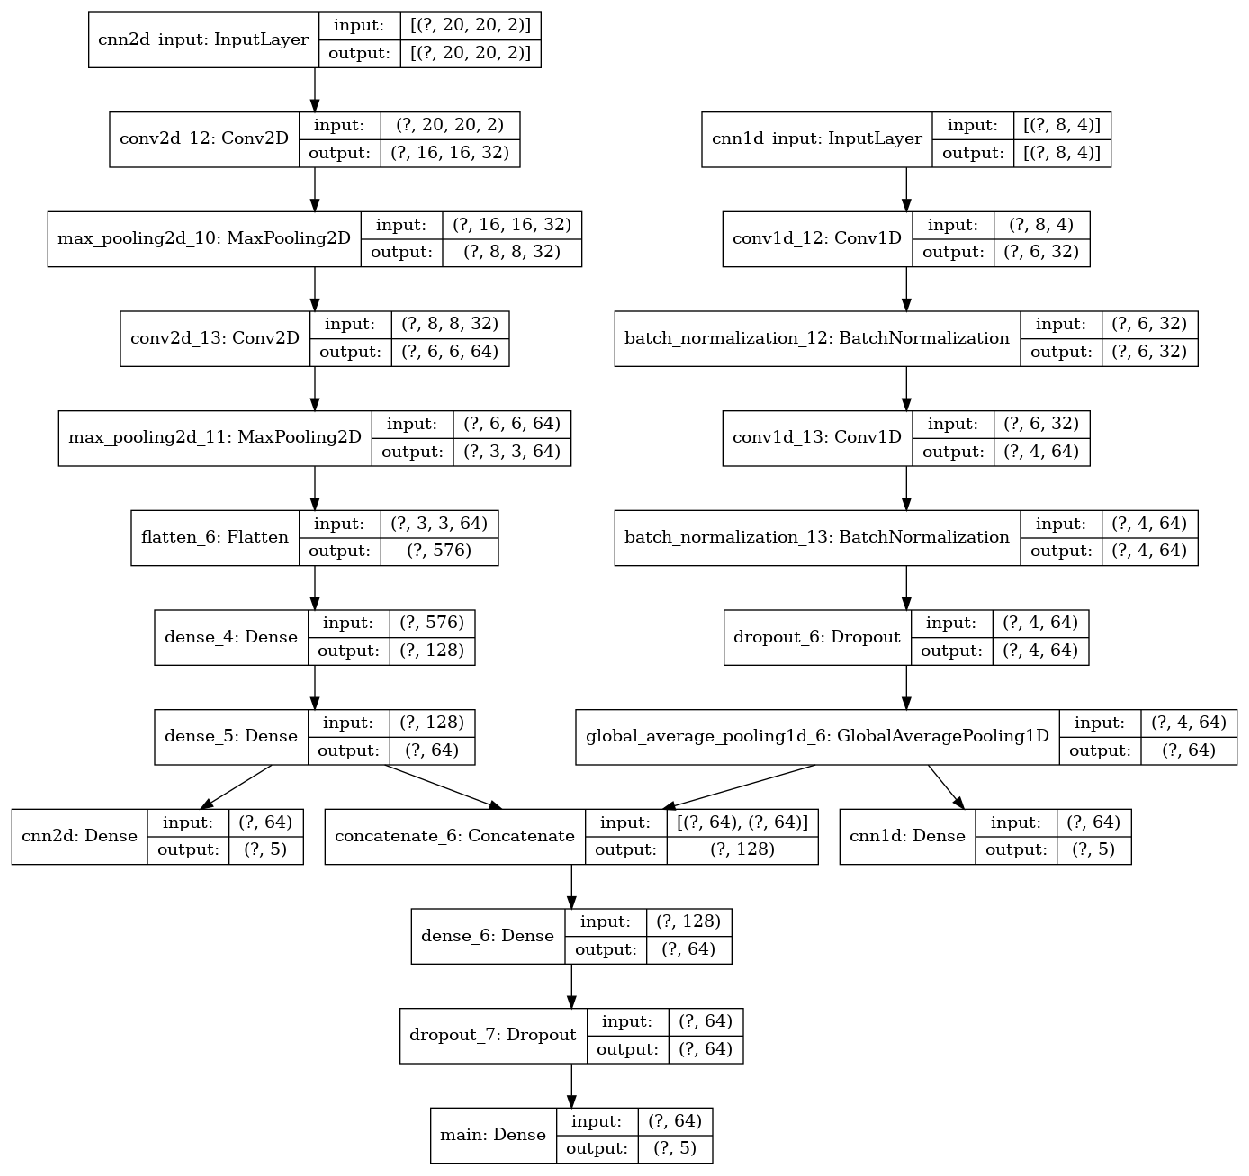

In [36]:
# Inputs 
cnn1d_input = Input(shape=(8, 4),name='cnn1d_input')
cnn2d_input = Input(shape=(20, 20, 2),name='cnn2d_input')

# CNN1D branch
cnn1d_layer1 = Conv1D(filters=32, kernel_size=5, activation='relu')(cnn1d_input)
cnn1d_layer1 = BatchNormalization()(cnn1d_layer1)

cnn1d_layer2 = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn1d_layer1)
cnn1d_layer2 = BatchNormalization()(cnn1d_layer2)
cnn1d_layer2 = Dropout(0.5)(cnn1d_layer2)

cnn1d_layer3 = GlobalAveragePooling1D()(cnn1d_layer2)

cnn1d_out = Dense(5, activation='softmax', name='cnn1d')(cnn1d_layer3)

cnn1d_branch = Model(inputs=cnn1d_input, outputs=[cnn1d_layer3, cnn1d_out], name="cnn1d")

# CNN2D branch
cnn2d_layer1 = Conv2D(filters=32,kernel_size=(5,5),activation='relu')(cnn2d_input)
cnn2d_layer1 = MaxPooling2D(pool_size=(2, 2))(cnn2d_layer1)

cnn2d_layer2 = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(cnn2d_layer1)
cnn2d_layer2 = MaxPooling2D(pool_size=(2, 2))(cnn2d_layer2)

cnn2d_layer3 = Flatten()(cnn2d_layer2)
cnn2d_layer3 = Dense(128,activation='relu')(cnn2d_layer3)
cnn2d_layer3 = Dense(64,activation='relu')(cnn2d_layer3)

cnn2d_out = Dense(5,activation='softmax',name='cnn2d')(cnn2d_layer3)

cnn2d_branch = Model(inputs=cnn2d_input,outputs=[cnn2d_layer3,cnn2d_out],name="cnn2d")

# Concaténation des sorties des branches
concat = Concatenate()([cnn1d_branch.output[0],cnn2d_branch.output[0]])

# Un niveau Dense pour la classification
fc = Dense (64,activation='relu')(concat)
fc = Dropout (0.5)(fc)
out_layer = Dense(5,activation='softmax',name='main')(fc)

model = Model(inputs=[cnn1d_branch.input, cnn2d_branch.input], outputs=[out_layer, cnn1d_branch.output[1], cnn2d_branch.output[1]], name="cnn1d_cnn2d")

model.summary()

plot_model(model, 'Output/cnn1d_cnn2d.png', show_shapes=True)

display_image_in_actual_size('Output/cnn1d_cnn2d.png')

In [ ]:
OPTIMIZER = tf.keras.optimizers.Adam(0.001)
BATCH_SIZE = 256
EPOCHS = 25
CALLBACKS = [tf.keras.callbacks.ModelCheckpoint(
              'Model/model',
              verbose=1, # niveau de log
              monitor='val_main_acc', # nom de la métrique à surveiller
              save_best_only=True, # sauver uniquement le meilleur modèle
              save_weights_only=True)] # sauver uniquement les poids

model.compile(optimizer=OPTIMIZER, loss=tf.keras.losses.SparseCategoricalCrossentropy(), loss_weights=[1, .5, .5], metrics=tf.keras.metrics.SparseCategoricalAccuracy(name='acc'))

history = model.fit([train_X1, train_X2], train_y_enc, validation_data=([valid_X1, valid_X2], valid_y_enc), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=CALLBACKS)

Epoch 1/25
1766/1766 [==============================] - ETA: 0s - loss: 0.7745 - main_loss: 0.3641 - cnn1d_loss: 0.4291 - cnn2d_loss: 0.3917 - main_acc: 0.8809 - cnn1d_acc: 0.8610 - cnn2d_acc: 0.8650
Epoch 00001: val_main_acc improved from -inf to 0.83126, saving model to Model/model
1766/1766 [==============================] - 84s 47ms/step - loss: 0.7745 - main_loss: 0.3641 - cnn1d_loss: 0.4291 - cnn2d_loss: 0.3917 - main_acc: 0.8809 - cnn1d_acc: 0.8610 - cnn2d_acc: 0.8650 - val_loss: 1.0504 - val_main_loss: 0.4113 - val_cnn1d_loss: 0.9726 - val_cnn2d_loss: 0.3054 - val_main_acc: 0.8313 - val_cnn1d_acc: 0.7029 - val_cnn2d_acc: 0.8821
Epoch 2/25
1766/1766 [==============================] - ETA: 0s - loss: 0.5047 - main_loss: 0.2251 - cnn1d_loss: 0.3286 - cnn2d_loss: 0.2307 - main_acc: 0.9230 - cnn1d_acc: 0.8882 - cnn2d_acc: 0.9192
Epoch 00002: val_main_acc improved from 0.83126 to 0.90159, saving model to Model/model
1766/1766 [==============================] - 82s 47ms/step - loss: 0

1334/1766 [=====================>........] - ETA: 22s - loss: 0.1992 - main_loss: 0.0500 - cnn1d_loss: 0.2496 - cnn2d_loss: 0.0487 - main_acc: 0.9824 - cnn1d_acc: 0.9127 - cnn2d_acc: 0.9821

In [21]:
model.save('Model/Best_CNN1D_CNN2D')

model_loaded1 = model.load_weights('Model/model')
model_loaded2 = keras.models.load_model('Model/Best_CNN1D_CNN2D')

INFO:tensorflow:Assets written to: Model/Best_CNN1D_CNN2D/assets


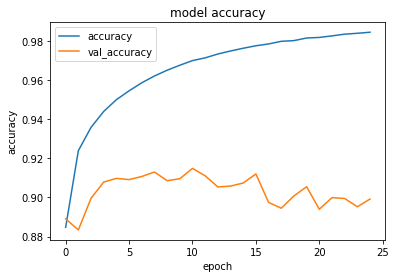

In [22]:
# summarize history for accuracy
plt.plot(history.history['main_acc'])
plt.plot(history.history['val_main_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

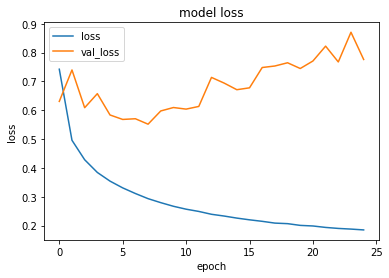

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [25]:
score = model.evaluate([valid_X1, valid_X2], valid_y_enc, batch_size=256)

print(f'Loss : {score[1]:.2f}')
print(f'Accuracy : {score[4]:.2f}')

600/600 [==============================] - 7s 12ms/step - loss: 0.6041 - main_loss: 0.3023 - cnn1d_loss: 0.3069 - cnn2d_loss: 0.2967 - main_acc: 0.9148 - cnn1d_acc: 0.8981 - cnn2d_acc: 0.9137
Loss : 0.30
Accuracy : 0.91


### **Prédiction des classes sur le jeu de validation et évaluation en aggrégeant au niveau objet**

In [26]:
# Récupérer les probabilités prédites sur le jeu de validation
valid_prob, _, _ = model.predict([valid_X1, valid_X2], batch_size=256)

# Retourner la classe correspondant à la probabilité la plus haute
valid_pred = np.argmax(valid_prob, axis=1) # axe 1 car ceci concerne chaque ligne

# Je réencode les prédictions entre 1 et 5
valid_pred_enc = encoder.inverse_transform(valid_pred)

# Aggrégation au niveau objet
out_pred = []
unique_id = np.unique(valid_id)
for ID in unique_id :
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = valid_pred_enc[np.where(valid_id==ID)]
    y_true = valid_y[np.where(valid_id==ID)]
    # Prendre la valeur majoritaire des prédictions sur les pixels
    out_pred.append([ np.bincount(y_true).argmax(), np.bincount(pred).argmax()]) #(Vérité terrain,Prédiction majoritaire)
out_pred = np.vstack(out_pred)
y_true = out_pred[:,0]
y_pred = out_pred[:,1]

In [27]:
cpt_mal_classes(y_true, y_pred)
print(f'F1 score : {f1_score(y_true,y_pred,average="weighted"):.2f}\n')
print(f'Accuracy : {accuracy_score(y_pred, y_true):.2f}\n')
print(f'Matrice de confusion :\n{confusion_matrix(y_true, y_pred)}\n')
print(f'Classification report :\n{classification_report(y_true, y_pred)}')

Taille des données 558 mal classés 60

F1 score : 0.89

Accuracy : 0.89

Matrice de confusion :
[[ 13   0   2   5   9]
 [  0  75   7   2   7]
 [  0   0  40   1   1]
 [  0   0  10  23   4]
 [  0   0   5   7 347]]

Classification report :
              precision    recall  f1-score   support

           1       1.00      0.45      0.62        29
           2       1.00      0.82      0.90        91
           3       0.62      0.95      0.75        42
           4       0.61      0.62      0.61        37
           5       0.94      0.97      0.95       359

    accuracy                           0.89       558
   macro avg       0.83      0.76      0.77       558
weighted avg       0.91      0.89      0.89       558



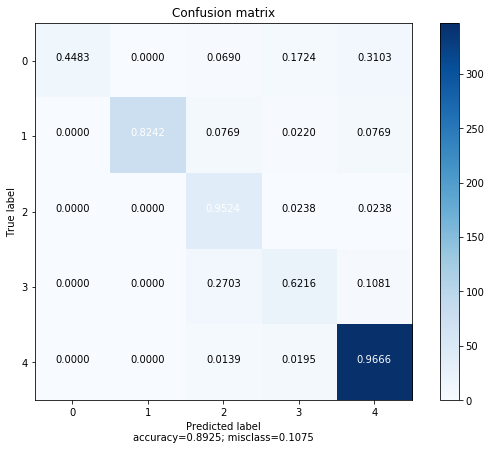

In [28]:
plot_confusion_matrix(confusion_matrix(y_true, y_pred), None)

### **Prédire sur le jeu test et Préparer une soumission**

In [29]:
# Récupérer les probabilités prédites sur le jeu test
test_prob, _, _ = model.predict([test_X1, test_X2], batch_size=256)

# Retourner la classe correspondant à la probabilité la plus haute
test_pred = np.argmax(test_prob, axis=1) # axe 1 car ceci concerne chaque ligne

# Je réencode les prédictions entre 1 et 5
test_pred_enc = encoder.inverse_transform(test_pred)

# Aggrégation au niveau objet
agg_pred = []
unique_id = np.unique(test_id)
for ID in unique_id :
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = test_pred_enc[np.where(test_id==ID)]
    # Prendre la valeur majoritaire des prédictions sur les pixels
    agg_pred.append([ ID, np.bincount(pred).argmax()]) #(ID,Prédiction majoritaire)
agg_pred = np.vstack(agg_pred)

In [30]:
df = pd.DataFrame({'ID':agg_pred[:, 0], 'Class':agg_pred[:, 1]})
df_test = pd.read_csv('Data/Test_id_Label.csv')

In [31]:
cpt_mal_classes(df_test.Class, df.Class)
print(f'F1 score : {f1_score(df_test.Class,df.Class,average="weighted"):.2f}\n')
print(f'Accuracy : {accuracy_score(df.Class, df_test.Class):.2f}\n')
print(f'Matrice de confusion :\n{confusion_matrix(df_test.Class, df.Class)}\n')
print(f'Classification report :\n{classification_report(df_test.Class, df.Class)}')

Taille des données 800 mal classés 100

F1 score : 0.88

Accuracy : 0.88

Matrice de confusion :
[[ 25   0   5   4   8]
 [  0 104  12   4  10]
 [  0   0  57   3   0]
 [  0   0  22  29   3]
 [  1   2  10  16 485]]

Classification report :
              precision    recall  f1-score   support

           1       0.96      0.60      0.74        42
           2       0.98      0.80      0.88       130
           3       0.54      0.95      0.69        60
           4       0.52      0.54      0.53        54
           5       0.96      0.94      0.95       514

    accuracy                           0.88       800
   macro avg       0.79      0.77      0.76       800
weighted avg       0.90      0.88      0.88       800



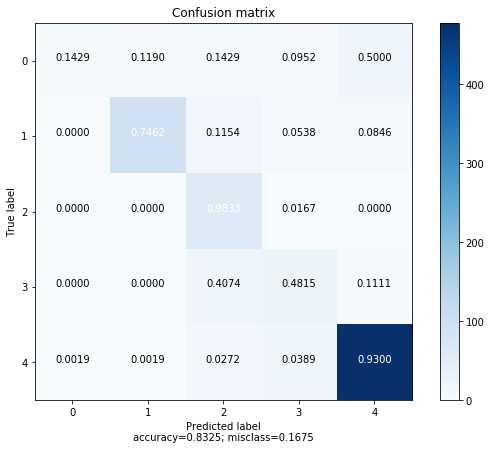

In [18]:
plot_confusion_matrix(confusion_matrix(df_test.Class, df.Class), None)